
# MediChal Challenge - Detecting Malaria with cell Images

____

<img src="./logo.jpg" width="200" height="200" align="left"> 

## Team MEDICHAL :
- Théo Deschamps-Berger
- Simon Monteiro
- Xienneng Xu
- Nicolas Devatine
- Clément Veyssière
- Corentin Leloup
- Ramine Hamidi


<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
        <br>       
 
     
The problem we try to solve here is the diagnosis of malaria using images of cells that are whether infected or not. It is a binary classification problem from the data set found here at <a href=https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria>"Cell images for detecting malaria"</a>. The data set contains around 27 thousand images, that are balanced between the 2 classes. The way we proceed here is to extract features from the images instead of using images directly as inputs to the model we use for predictions.

 
</div>

<p align="center">
  <img src="example_cells.png">
</p>
<center>Example of parasitized and uninfected cells</center>

In [245]:
import sys
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

### Quality of the data

Our data is composed of images that we preprocessed to extract features. Therefore we do not have any missing data in any feature because we created the features ourselves. There may be one artefact which is the fact that the background is black, and we may wonder if infected cells might be smaller (or the contrary), which would provide us darker images and a higher (or lower) average of gray 

In [246]:
data_dir = 'public_data'              # Change this to the directory where you put the input data
data_name = 'malaria'

!ls $data_dir* # Linux command
# !dir $data_dir # Windows command

malaria_feat.name    malaria_test.data	     malaria_valid.data
malaria_label.name   malaria_train.data
malaria_public.info  malaria_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

Reading public_data/malaria_train from AutoML format
Number of examples = 16534
Number of features = 19
         Class
0   uninfected
1  parasitized
Number of classes = 2


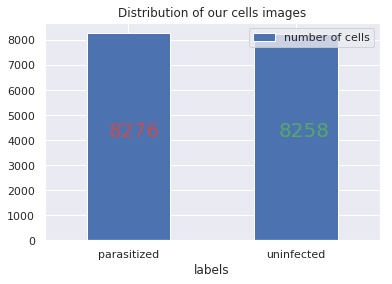

In [247]:
from data_io import read_as_df
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

nb_p=np.sum(data.target == 'parasitized')
nb_u=np.sum(data.target == 'uninfected')

p = pd.DataFrame({'labels':['parasitized', 'uninfected'],'number of cells': [nb_p, nb_u]})
ax = p.plot.bar(x='labels', y='number of cells', rot=0),
plt.text(-0.12, nb_p/2, nb_p , size=20, color='r'),
plt.text(0.9, nb_u/2, nb_u , size=20, color='g'),plt.title('Distribution of our cells images')
plt.show()

In [248]:
data.head()

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0,target
0,4884,0.000000,0.948893,0.948893,0.948893,0.419515,0.636039,0.529412,0.764706,0,0,0,0,0,0,0,1038,9482,1886,uninfected
1,4347,0.000311,0.907223,0.874799,0.927769,0.519111,0.633702,0.400000,0.823529,0,0,0,0,0,1,79,6716,4333,656,parasitized
2,4935,0.000033,0.972043,0.962162,0.985586,0.266897,0.641619,0.568627,0.737255,0,0,0,0,0,0,0,0,8647,4506,uninfected
3,6501,0.000017,0.955153,0.950617,0.959436,0.594517,0.661221,0.301961,0.745098,0,0,0,0,4,25,122,367,8520,5813,parasitized
4,3384,0.000189,0.870487,0.857143,0.911565,2.217611,0.471401,0.345098,0.780392,0,0,0,0,0,1966,2513,1448,798,191,uninfected


We have decided to reduce the dataset of images to a simpler dataset with only 19 features.

`nb_black_pixels` counts pixels whose value is dark for gray_scale images, those around the cell in the image.

`var_color` feature is simply the empirical variance of the values of the pixels for colored images.

`mean_color` feature is simply the mean of the values of the pixels for colored images.

`max_color` is the maximum value for colored images.

`min_color` is the maximum value for colored images.

`var_gray`, `mean_gray`, `max_gray` and `min_gray` are the same but for gray-scale images.

`nb_pixel_i_j` is the number of pixels having their value (intensity : 0 = black | 1 = white) between i and j for gray-scale images.

In [249]:
data.describe() 

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0
count,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.0,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000
mean,5186.434861,0.000187,0.932538,0.915922,0.951003,0.455423,0.638756,0.425941,0.767492,0.0,0.023588,0.068828,0.825390,9.424398,39.726261,255.600641,1700.682533,7205.277186,3425.218157
std,2555.612474,0.000685,0.042827,0.050649,0.038777,0.401030,0.047318,0.166523,0.034910,0.0,2.398723,3.554840,10.868906,34.948790,148.352439,944.844381,2869.953967,4015.087123,3777.575870
min,720.000000,0.000000,0.361582,0.308397,0.361582,0.013198,0.399673,0.062745,0.564706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,3753.000000,0.000028,0.912136,0.892857,0.933333,0.169282,0.614504,0.262745,0.749020,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3781.000000,944.000000
50%,4641.000000,0.000070,0.942715,0.926871,0.960345,0.357243,0.646235,0.431373,0.764706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,190.000000,7634.500000,1913.000000
75%,5848.500000,0.000161,0.963064,0.950949,0.978261,0.614151,0.671711,0.592157,0.788235,0.0,0.000000,0.000000,0.000000,3.000000,49.000000,108.000000,1966.000000,10215.000000,4317.750000
max,79306.000000,0.030410,1.000000,1.000000,1.000000,7.691629,0.748599,0.705882,0.941176,0.0,295.000000,305.000000,1026.000000,1595.000000,5492.000000,12863.000000,17071.000000,29463.000000,30574.000000


Histogram of our features:

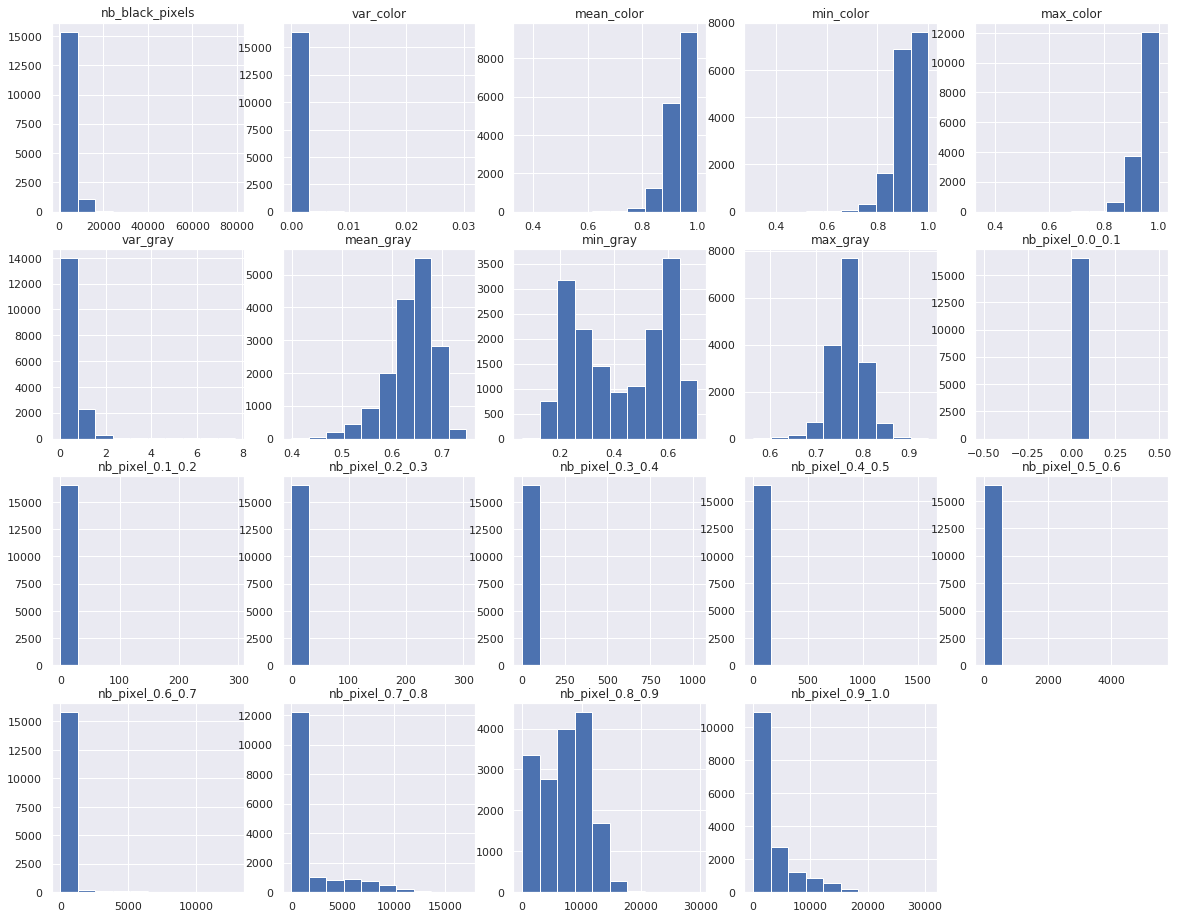

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.hist(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features.

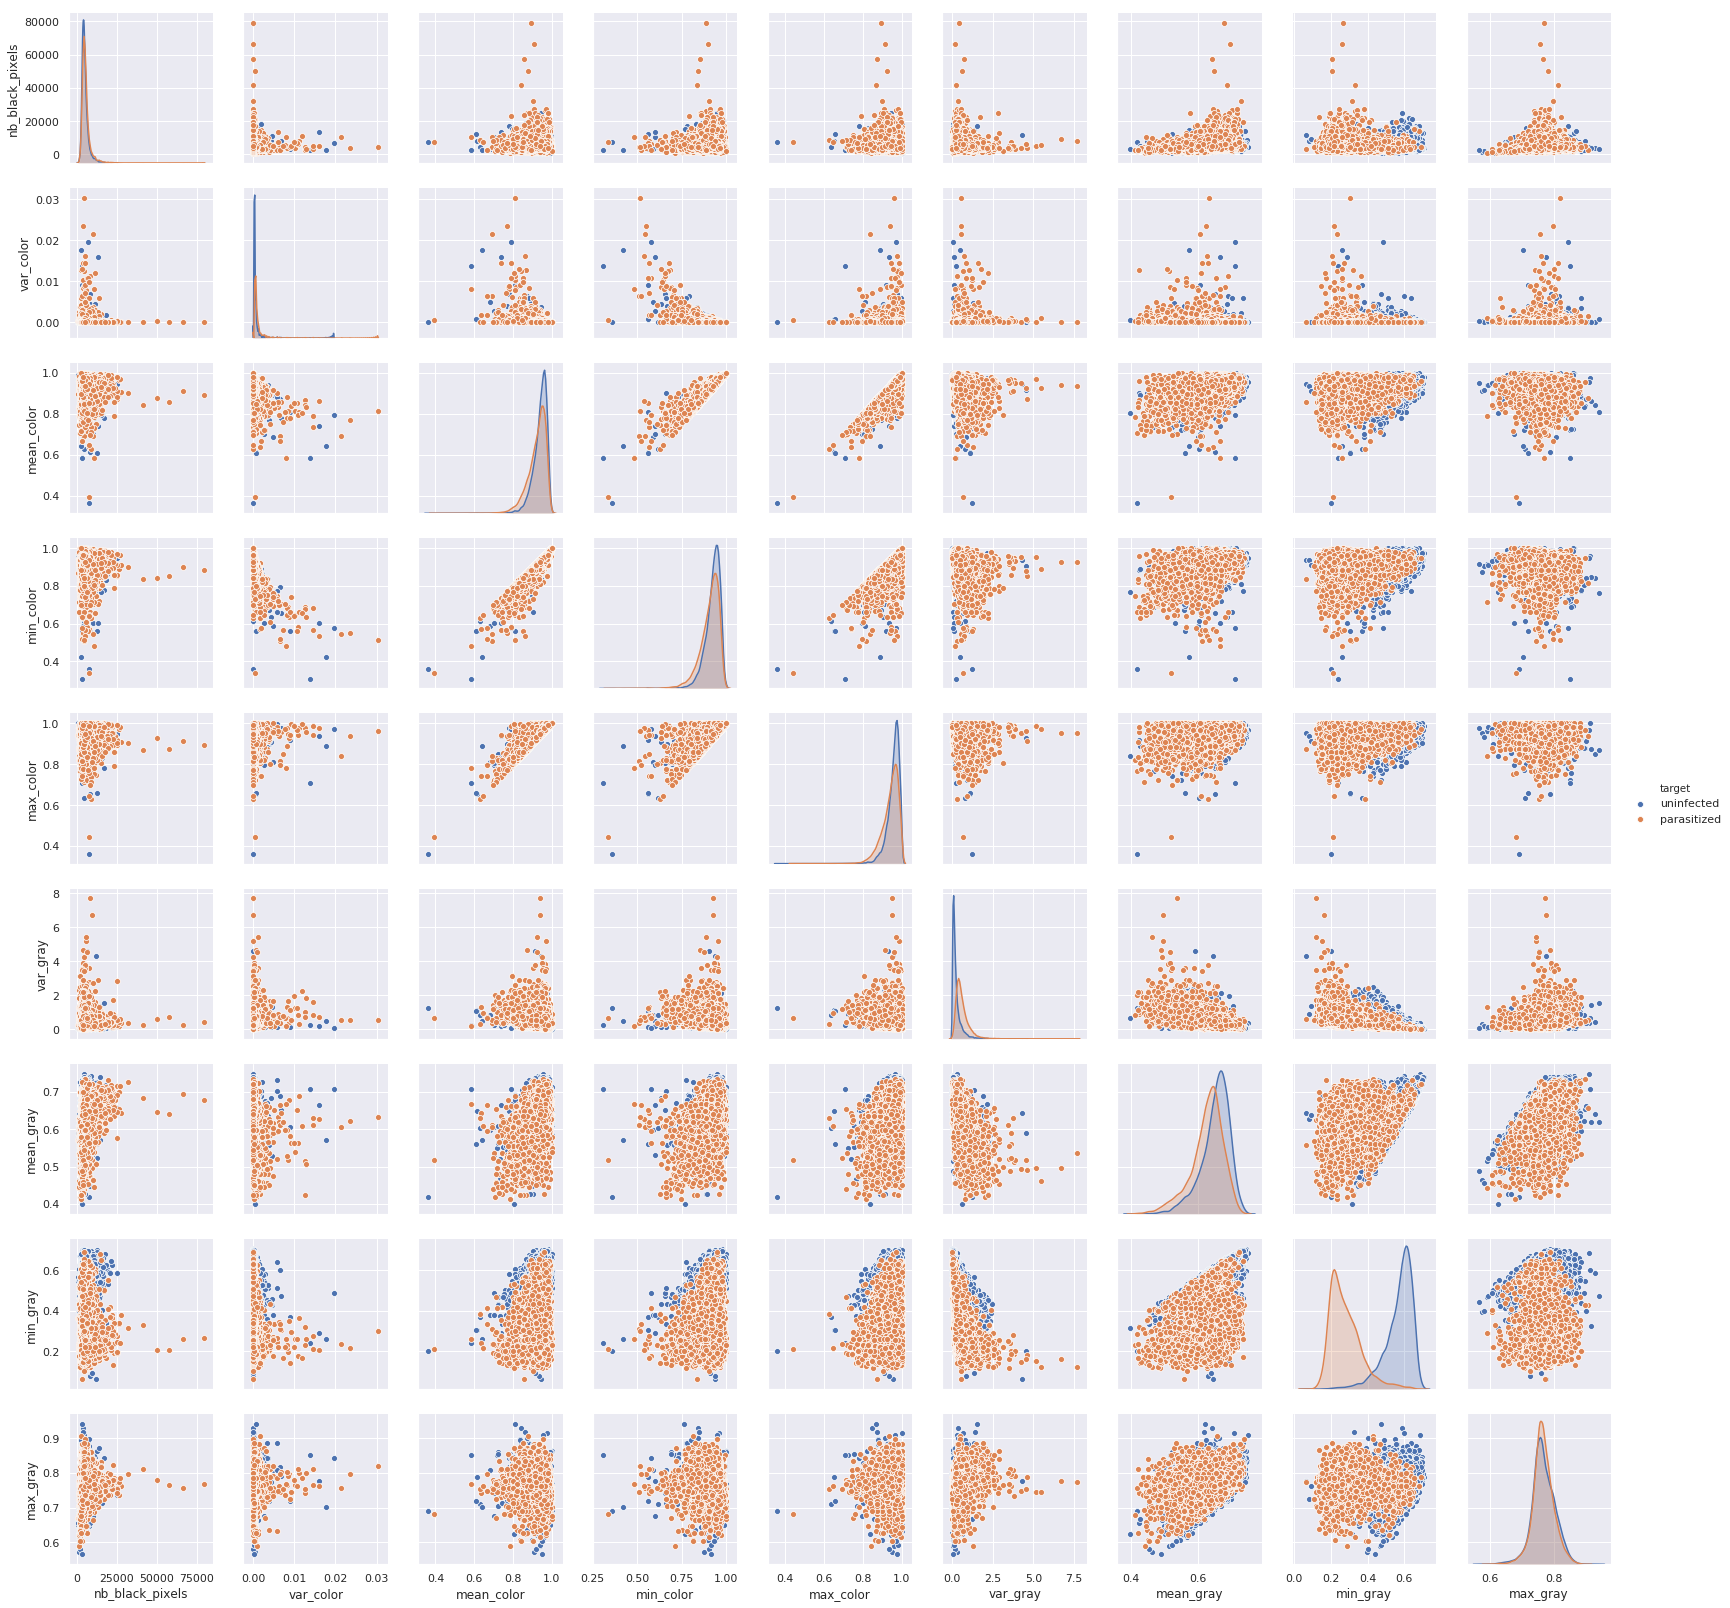

In [251]:
sns.pairplot(data[['target','nb_black_pixels','var_color','mean_color','min_color','max_color','var_gray','mean_gray','min_gray','max_gray']], hue="target")

Correlation of our features with the target: 'parasitized'

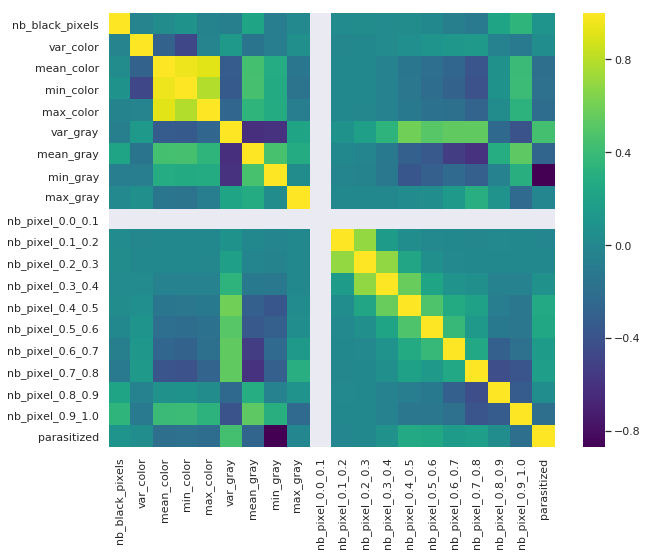

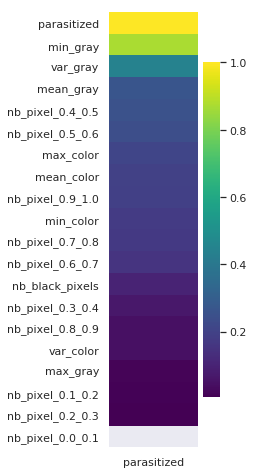

In [252]:
datatarget = pd.get_dummies(data['target'])['parasitized'].to_frame()
new_df = pd.merge(data, datatarget, right_index=True, left_index=True)
df_new = new_df.select_dtypes(include=np.number)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(df_new.corr(),cmap="viridis", xticklabels=True, yticklabels=True)

d=pd.get_dummies(data['target'])['parasitized']

n_df = pd.merge(d.to_frame(), data, right_index=True, left_index=True)
df_n = n_df.select_dtypes(include=np.number).abs()


plt.figure(figsize = (2, 8))
ax = sns.heatmap(df_n.corr().abs().sort_values(['parasitized'], ascending=[0])["parasitized"].to_frame(), cmap="viridis", xticklabels=True, yticklabels=True)

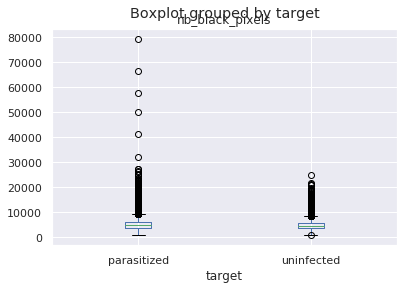

In [253]:
boxplot = data.boxplot(column=['nb_black_pixels'], by='target', )

There seem to have no correlation between the number of black pixels and the target as well, then there is no dataleakage.

From the correlation matrix, the feature that has the highest correlation with the target is "min_gray".

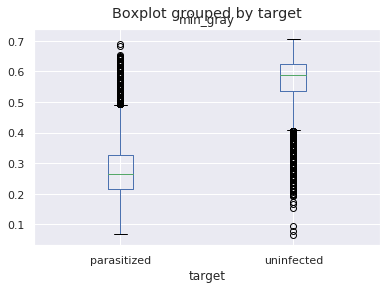

In [254]:
boxplot = data.boxplot(column=['min_gray'], by='target', )

## Model and results analysis

Here we run a sandbox test to introduce some metrics and ways to visualize results. We split the train set into train and test in order to perform these analysis, and we compute the confusion matrix for RandomForestClassifier with arbitrary hyper-parameters.

In [255]:
data_name

'malaria'

In [256]:
from sklearn.model_selection import train_test_split
from data_manager import DataManager
from model import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

D = DataManager(data_name, data_dir, replace_missing=True)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=0.33, random_state=42)

# Load model
clf = RandomForestClassifier(random_state = 42, n_estimators = 2, max_depth = 5)
M = model() # The model is by default a random forest classifier

if not(M.is_trained):
    M.fit(X_train_pre, y_train_pre)                     

Y_hat_test_pre = M.predict(X_test_pre)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pre, Y_hat_test_pre)

Info file found : /home/tp-home003/mvincen1/L2/S4/malaria/starting_kit/public_data/malaria_public.info
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]


array([[2570,  105],
       [ 158, 2624]])

This is the plot of the confusion matrix from the predictions performed.

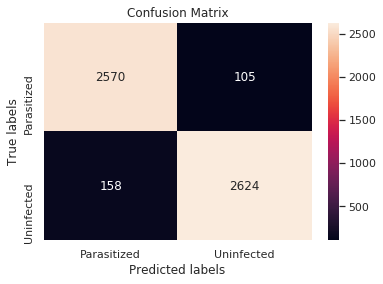

In [257]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test_pre, Y_hat_test_pre), annot=True, fmt='g', ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Parasitized', 'Uninfected']);
ax.yaxis.set_ticklabels(['Parasitized', 'Uninfected']);
plt.show()

In [258]:
from sklearn.metrics import classification_report

target_names = ['Parasitized', 'Uninfected']
print(classification_report(y_test_pre, Y_hat_test_pre, target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.94      0.96      0.95      2675
  Uninfected       0.96      0.94      0.95      2782

   micro avg       0.95      0.95      0.95      5457
   macro avg       0.95      0.95      0.95      5457
weighted avg       0.95      0.95      0.95      5457



Then we can compute the AUC metric which is the one used for the submission.

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [259]:
from data_io import write

# Importation des modèles de classification
from sklearn.linear_model import Perceptron # Perceptron simple
from sklearn.neural_network import MLPClassifier # Perceptron multi-couche
from sklearn.neighbors import KNeighborsClassifier # K-voisins
from sklearn.gaussian_process import GaussianProcessClassifier # Mixture de gaussiennes
from sklearn.tree import DecisionTreeClassifier # Arbre de décision
from sklearn.ensemble import RandomForestClassifier # Foret d'arbres de décision

# Uncomment the next line to show the code of the model
#??model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [260]:
# Gestion des jeux de données, on peut noter que les labels
# de valid et test sont indisponibles dans public_data
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
# Séparation de l'ensemble d'apprentissage en un plus petit ensemble d'apprentissage et un ensemble de test
X_train, X_test, Y_train, Y_test = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=0.33, random_state=42)
print("Taille Apprentissage =", len(X_train))
print("Taille Test =", len(X_test))

Info file found : /home/tp-home003/mvincen1/L2/S4/malaria/starting_kit/public_data/malaria_public.info
Taille Apprentissage = 11077
Taille Test = 5457


In [261]:
# Instanciation de tous les algorithmes

# Perceptron simple
P = model(Perceptron())
trained_P = model_dir + data_name + "_P"

# Perceptron multi-couche
MLP = model(MLPClassifier())
trained_MLP = model_dir + data_name + "_MLP"

# K-voisins
KN = model(KNeighborsClassifier())
trained_KN = model_dir + data_name + "_KN"

# Mixture de gaussiennes
#G = model(GaussianProcessClassifier())
#trained_G = model_dir + data_name + "_G"

# Arbre de décision
T = model(DecisionTreeClassifier())
trained_T = model_dir + data_name + "_T"

# Forêt d'arbres de décision
F = model(RandomForestClassifier())
trained_F = model_dir + data_name + "_F"

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

We use the area under the curve as our metric to evaluate our model for the moment. We chose this metric because accuracy gives us only the percentage of correctly classified examples, whereas what we are interested in is to have the lowest possible rate of false negatives (infected cells classifies as being healthy). The ROC curve we will get will help us to find a good threshold for this classification, which will not necessarily the one maximising the accuracy as the false negatives are critical in our case (but the true negatives can always be rechecked by experts). The AUC will then give us the general performance of our model given the fact that we want to maximize true positives and true negatives.

In [262]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: roc_auc_score


In [263]:
# Fonction de sauvegarde du meilleur modèle et des labels prédits
# Returns: Le score du meilleur modèle
def save_best_model(grid, trained_model_name, result_name):
    global X_train, Y_train, X_test, Y_test
    # Meilleurs paramètres du modèle
    M = grid.best_estimator_; print(M)
    # Entraînement du modèle
    M.fit(X_train, Y_train)
    # Enregistrement du modèle
    M.save(trained_model_name)
    # Enregistrement des labels prédits
    write(result_name + '_train.predict', M.predict(X_train))
    write(result_name + '_test.predict', M.predict(X_test))
    # Score du modèle
    return scoring_function(Y_train, M.predict(X_train))

In [264]:
# Dictionnaire des scores de chacun des meilleurs modèles
algorithm_scores = dict()

In [265]:
# Paramètres du perceptron simple
P.get_params().keys()

dict_keys(['classifier__alpha', 'classifier__class_weight', 'classifier__early_stopping', 'classifier__eta0', 'classifier__fit_intercept', 'classifier__max_iter', 'classifier__n_iter', 'classifier__n_iter_no_change', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__shuffle', 'classifier__tol', 'classifier__validation_fraction', 'classifier__verbose', 'classifier__warm_start', 'classifier'])

In [266]:
# Recherche des meilleurs hyperparamètres selon la fonction de score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# On choisit une grille de recherche aléatoire de 100 itérations pour
# gagner du temps d'exécution

### Perceptron simple ###

# Paramètres à tester
parameters={"classifier__penalty":["l2", "l1", "elasticnet", None], "classifier__alpha":[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
            "classifier__max_iter":[i for i in range(100,1100,100)], "classifier__eta0":[0.001,0.01,0.1,1.0]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = RandomizedSearchCV(P, parameters, scoring=make_scorer(scoring_function), n_jobs=-1, n_iter=100)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=model(classifier=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'classifier__penalty': ['l2', 'l1', 'elasticnet', None], 'classifier__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'classifier__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'classifier__eta0': [0.001, 0.01, 0.1, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [268]:
### Perceptron simple ###

# Sauvegarde du modèle
algorithm_scores["Perceptron"] = save_best_model(grid, trained_P, result_dir + data_name + "_P")

model(classifier=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.001,
      fit_intercept=True, max_iter=600, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [269]:
# Paramètres du perceptron multi-couche
MLP.get_params().keys()

dict_keys(['classifier__activation', 'classifier__alpha', 'classifier__batch_size', 'classifier__beta_1', 'classifier__beta_2', 'classifier__early_stopping', 'classifier__epsilon', 'classifier__hidden_layer_sizes', 'classifier__learning_rate', 'classifier__learning_rate_init', 'classifier__max_iter', 'classifier__momentum', 'classifier__n_iter_no_change', 'classifier__nesterovs_momentum', 'classifier__power_t', 'classifier__random_state', 'classifier__shuffle', 'classifier__solver', 'classifier__tol', 'classifier__validation_fraction', 'classifier__verbose', 'classifier__warm_start', 'classifier'])

In [270]:
### Perceptron multi-couche ###

# Paramètres à tester
parameters={'classifier__hidden_layer_sizes':[i for i in range(5,150,5)], 'classifier__activation':["identity", "logistic", "tanh", "relu"],
           'classifier__solver':["lbfgs", "sgd", "adam"], 'classifier__alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
           'classifier__learning_rate':["constant", "invscaling", "adaptive"], 'classifier__max_iter':[50,100,150,200,300,400,500]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = RandomizedSearchCV(MLP, parameters, scoring=make_scorer(scoring_function), n_jobs=-1,  n_iter=100)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=model(classifier=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'classifier__hidden_layer_sizes': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145], 'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'], 'classifier__solver': ['lbfgs', 'sgd', 'adam'], 'classifier__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], 'classifier_

In [271]:
### Perceptron multi-couche ###

# Sauvegarde du modèle
algorithm_scores["MLPClassifier"] = save_best_model(grid, trained_MLP, result_dir + data_name + "_MLP")

model(classifier=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=150, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [272]:
# Paramètres des k-voisins
KN.get_params().keys()

dict_keys(['classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights', 'classifier'])

In [273]:
### K-voisins ###

# Paramètres à tester
parameters={'classifier__n_neighbors':[i for i in range(1,20)], 'classifier__algorithm':["ball_tree", "kd_tree", "brute"]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = GridSearchCV(KN, parameters, scoring=make_scorer(scoring_function), n_jobs=-1)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=model(classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'classifier__algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [274]:
### K-voisins ###

# Sauvegarde du modèle
algorithm_scores["KNeighborsClassifier"] = save_best_model(grid, trained_KN, result_dir + data_name + "_KN")

model(classifier=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform'))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [275]:
### K-voisins ###

# D'après la grille de recherche précédente, l'algorithme ball_tree est meilleur
# pour les k-voisins. On peut affiner les paramètres.

# Paramètres à tester
parameters={'classifier__n_neighbors':[i for i in range(1,20)], 'classifier__algorithm':["ball_tree"],
           'classifier__leaf_size':[i for i in range(1,50)], 'classifier__weights':["uniform", "distance"],
           'classifier__metric':["euclidean", "manhattan", "chebyshev", "minkowski"]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = RandomizedSearchCV(KN, parameters, scoring=make_scorer(scoring_function), n_jobs=-1, n_iter=100)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=model(classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'classifier__algorithm': ['ball_tree'], 'classifier__leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [276]:
### K-voisins ###

# Sauvegarde du modèle
algorithm_scores["KNeighborsClassifier"] = save_best_model(grid, trained_KN, result_dir + data_name + "_KN")

model(classifier=KNeighborsClassifier(algorithm='ball_tree', leaf_size=25, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='distance'))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [277]:
# Paramètres de la mixture de gaussiennes
#G.get_params().keys()

In [278]:
### Mixture de gaussiennes ###

# ATTENTION !!! Abandon de la mixture de gaussiennes car trop gourmande en ressources

# Paramètres à tester
#parameters={'classifier__n_restarts_optimizer':[i for i in range(0,10)], 'classifier__max_iter_predict':[i for i in range(25,300,25)],
#          'classifier__warm_start':[True, False]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
#grid = RandomizedSearchCV(G, parameters, scoring=make_scorer(scoring_function), n_jobs=-1, n_iter=10)
# Lancement des entrainements
#grid.fit(X_train, Y_train)

In [279]:
### Mixture de gaussiennes ###

# Sauvegarde du modèle
#algorithm_scores["GaussianProcessClassifier"] = save_best_model(grid, trained_G, result_dir + data_name + "_G")

In [280]:
# Paramètres de l'arbre de décision
T.get_params().keys()

dict_keys(['classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__presort', 'classifier__random_state', 'classifier__splitter', 'classifier'])

In [281]:
### Arbre de décision ###

# Paramètres à tester
parameters_tree={'classifier__criterion':["gini", "entropy"], 'classifier__splitter':["best", "random"],
           'classifier__max_depth':[i for i in range(1,10)]+[None], 'classifier__min_samples_split':[i for i in range(2,5)],
           'classifier__min_samples_leaf':[i for i in range(1,5)]}
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = GridSearchCV(T, parameters_tree, scoring=make_scorer(scoring_function), n_jobs=-1)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=model(classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__criterion': ['gini', 'entropy'], 'classifier__splitter': ['best', 'random'], 'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None], 'classifier__min_samples_split': [2, 3, 4], 'classifier__min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [282]:
### Arbre de décision ###

# Sauvegarde du modèle
algorithm_scores["DecisionTreeClassifier"] = save_best_model(grid, trained_T, result_dir + data_name + "_T")

model(classifier=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [283]:
# Paramètres de la forêt d'arbres
F.get_params().keys()

dict_keys(['classifier__bootstrap', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start', 'classifier'])

In [284]:
### Forêt d'arbres ###

# Paramètres à tester
parameters_tree['classifier__n_estimators'] = [i for i in range(10,300,10)]
del parameters_tree['classifier__splitter']
# Grille de recherche en utilisant toute la puissance processeur et paramétrée avec la fonction de score
grid = RandomizedSearchCV(F, parameters_tree, scoring=make_scorer(scoring_function), n_jobs=-1, n_iter=100)
# Lancement des entrainements
grid.fit(X_train, Y_train)

FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=model(classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None], 'classifier__min_samples_split': [2, 3, 4], 'classifier__min_samples_leaf': [1, 2, 3, 4], 'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]},
          pre_

In [285]:
### Forêt d'arbres ###

# Sauvegarde du modèle
algorithm_scores["RandomForestClassifier"] = save_best_model(grid, trained_F, result_dir + data_name + "_F")

model(classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]
PREDICT: dim(X)= [11077, 19]
PREDICT: dim(y)= [11077, 1]


In [286]:
# Affichage des scores de chaque algorithme avec
# les meilleurs hyperparamètres
print(algorithm_scores)
# Meilleur modèle parmi ceux testés
best_model = max([(algorithm_scores[algo], algo) for algo in algorithm_scores.keys()])[1]
print("Best model =", best_model)

{'Perceptron': 0.8428046592896256, 'MLPClassifier': 0.9340020256250104, 'KNeighborsClassifier': 1.0, 'DecisionTreeClassifier': 0.9481340463512504, 'RandomForestClassifier': 0.9845173615546335}
Best model = KNeighborsClassifier


<div style="background:#009999 ">
Les algorithmes obtenant les meilleurs score sont celui des "k plus proche voisin" et des "Processus gaussien", 
les deux algorithme s'égalisent sur le score maximun cette à dire 1.0, le score idéal.
On peut aussi noter le "random forest" avec un score proche de 0.99, qui offre l'avantage d'observer l'importance de chaque feature individuellement.
</div>

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

You can add here other scores and result visualization.

<div style="background:#009999 ">
On observe un taux de faux positif est élévé, cela est dû à un acte volontaire d'être plus tolérant sur le seul 
d'acceptation de l'infection de la cellule. La conséquence est une diminution de vrai négatif ce qui est impératif dans le cas d'une épidémie par exemple, la malaria n'étant pas contagieuse d'humain à humain ce choix peut "éventuellement" être remis en question en fonction du coût du vaccin, du traitement et de sa quantité de production etc... (Optimisation spécifique)
</div>

In [289]:
from sklearn.metrics import roc_curve, auc

size = round(len(D.data['X_train'])/10)

probas_ = M.classifier.fit(D.data['X_train'][:size], D.data['Y_train'][:size].ravel()).predict_proba(D.data['X_train'][size:])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(D.data['Y_train'][size:].ravel(), probas_[:, 1])
roc_auc = auc(fpr, tpr)

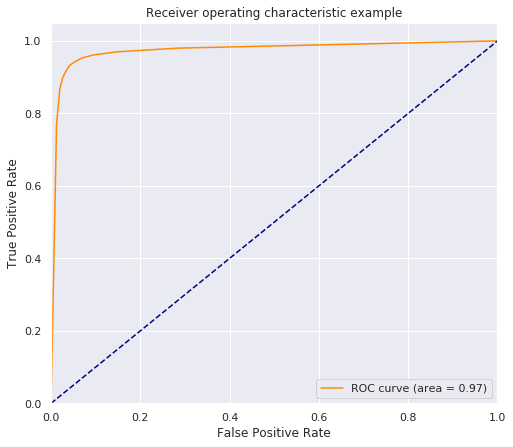

In [290]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This plot of the ROC curve is a good indicator for us to find a good threshold for our model, here we will prefer a very low rate of false negatives (1 - true positives rate). If we really want something near to 100% true positives, we might consider a model giving us 40% of false positive rate, we might consider that threshold as a medical diagnosis is a critical application.

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [291]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

def cross_validation_score(trained_model_name):
    scores = cross_val_score(trained_model_name, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
    return scores

In [293]:
algorithm_cross_val_score = dict()

In [295]:
print("Perceptron:")
algorithm_cross_val_score["Perceptron"] = cross_validation_score(P.load(trained_P))

print("Perceptron multi-couche:")
algorithm_cross_val_score["MLPClassifier"] = cross_validation_score(MLP.load(trained_MLP))

print("K-voisins:")
algorithm_cross_val_score["KNeighborsClassifier"] = cross_validation_score(KN.load(trained_KN))

#print("Mixture de gaussienne:")
#algorithm_cross_val_score["GaussianProcessClassifier"] = cross_validation_score(G.load(trained_G))

print("Arbre de décision:")
algorithm_cross_val_score["DecisionTreeClassifier"] = cross_validation_score(T.load(trained_T))
                       
print("Forêt d'arbres de décision:")
algorithm_cross_val_score["RandomForestClassifier"] = cross_validation_score(F.load(trained_F))


Perceptron:
Model reloaded from: sample_code_submission/malaria_P_model.pickle
FIT: dim(X)= [8861, 19]
FIT: dim(y)= [8861, 1]
PREDICT: dim(X)= [2216, 19]
PREDICT: dim(y)= [2216, 1]
FIT: dim(X)= [8861, 19]
FIT: dim(y)= [8861, 1]
PREDICT: dim(X)= [2216, 19]
PREDICT: dim(y)= [2216, 1]
FIT: dim(X)= [8862, 19]
FIT: dim(y)= [8862, 1]
PREDICT: dim(X)= [2215, 19]
PREDICT: dim(y)= [2215, 1]
FIT: dim(X)= [8862, 19]
FIT: dim(y)= [8862, 1]
PREDICT: dim(X)= [2215, 19]
PREDICT: dim(y)= [2215, 1]
FIT: dim(X)= [8862, 19]
FIT: dim(y)= [8862, 1]
PREDICT: dim(X)= [2215, 19]
PREDICT: dim(y)= [2215, 1]

CV score (95 perc. CI): 0.80 (+/- 0.09)
Perceptron multi-couche:
Model reloaded from: sample_code_submission/malaria_MLP_model.pickle
FIT: dim(X)= [8861, 19]
FIT: dim(y)= [8861, 1]
PREDICT: dim(X)= [2216, 19]
PREDICT: dim(y)= [2216, 1]
FIT: dim(X)= [8861, 19]
FIT: dim(y)= [8861, 1]
PREDICT: dim(X)= [2216, 19]
PREDICT: dim(y)= [2216, 1]
FIT: dim(X)= [8862, 19]
FIT: dim(y)= [8862, 1]
PREDICT: dim(X)= [2215, 1

In [296]:
print(algorithm_cross_val_score)

{'Perceptron': array([0.72599467, 0.82402581, 0.80567672, 0.79688208, 0.85521877]), 'MLPClassifier': array([0.92569314, 0.92912672, 0.92550715, 0.92686473, 0.92141275]), 'KNeighborsClassifier': array([0.77810411, 0.75987629, 0.7778031 , 0.77609787, 0.78107283]), 'DecisionTreeClassifier': array([0.93784265, 0.94585403, 0.94581771, 0.94718015, 0.93140375]), 'RandomForestClassifier': array([0.95013902, 0.96479327, 0.95302897, 0.95259776, 0.94717762])}


In [297]:
def check_over_fitting():
    global algorithm_scores, algorithm_cross_val_score
    resultat = dict()
    # Calcul de la moyenne des validations
    mean_cross_val = dict()
    for key in algorithm_cross_val_score.keys():
        mean_cross_val[key] = algorithm_cross_val_score[key].mean()
    # Comparaison des scores avec différence 10%
    for key in algorithm_cross_val_score.keys():
        resultat[key] = (algorithm_scores[key] - mean_cross_val[key] >= 0.1)
    return resultat
    

In [298]:
check_over_fitting()

{'Perceptron': False,
 'MLPClassifier': False,
 'KNeighborsClassifier': True,
 'DecisionTreeClassifier': False,
 'RandomForestClassifier': False}

The scores of our model with and without the nb_black_pixels attribute is the same. Therefore we can conclude that there is no data leakage.

____

### Feature importance

The advantage of using a Random forest models is that we can evaluate which feature in taken into account  when predicting the target classes, here you can have an idea of which feature was the most relevant for solving our task

In [ ]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:19], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance.plot.bar(figsize=(9,7))
plt.show()



<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

## Parameter optimization to try to improve the area under the roc curve.

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

# import os
# import sys
# sys.stdout = open(os.devnull, 'w')

# Define the hyperparameters
hyperparameters = {
    'max_depth': [5, 10, 20,40], 
    'n_estimators' : [2,10, 20, 100] }

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
#resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])
resultsDF = pd.DataFrame()

for parameter_combination in parameter_grid:    
    clf = RandomForestClassifier (random_state = 42, n_estimators =parameter_combination['n_estimators'],max_depth =parameter_combination['max_depth'])
    M = model (classifier=clf)
    
    
    scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    
    
    parameter_combination['auc'] = scores.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
res = resultsDF.sort_values(by=['auc'], ascending=False)


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir

the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)